[[-0.11425234 -0.28764637 -0.65064024 ...  3.57547909  0.8867652
  -0.63076268]
 [-1.21433669 -0.90572665 -1.57441152 ... -1.13243416 -0.39188809
  -0.66588395]
 [ 0.73441097 -0.28798975 -0.68628062 ...  0.55758598  0.65714367
   1.96843552]
 ...
 [ 0.57551288  1.9824052  -0.40127266 ... -0.53982969  0.2350831
  -0.71052647]
 [-0.95755201 -0.48670397 -0.96065669 ... -0.04599264 -0.16064092
   1.19122132]
 [-0.52644874 -0.12628178 -1.51955584 ... -0.30466919 -1.07725623
   0.08493469]]
dict_keys(['val_loss', 'val_mse', 'val_mae', 'loss', 'mse', 'mae'])
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 37)                1406      
_________________________________________________________________
dropout_1 (Dropout)          (None, 37)                0         
_________________________________________________________________
dense_2 (Dense)         

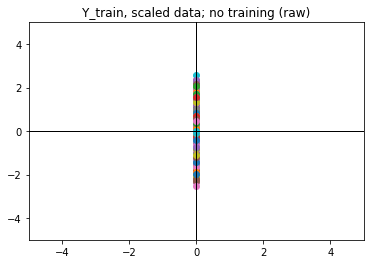

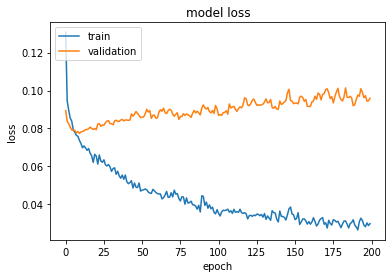

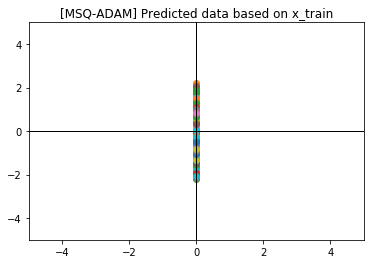

In [8]:
import librosa
import numpy

def load(file):
    y, sr = librosa.load(file, mono=True, duration=10)
    
    onset_env = librosa.onset.onset_strength(y, sr=sr)
    out = {
        'filename': file,
        'arousal': 0,
        'valence': 0,
        # Mel-based Power Spectrogram
        'melspectrogram': numpy.mean(librosa.feature.melspectrogram(y=y, sr=sr)),
        # Tempo features
        'tempo': numpy.mean(librosa.beat.tempo(onset_envelope=onset_env, sr=sr)),
        'tempo_std': numpy.std(librosa.beat.tempo(onset_envelope=onset_env, sr=sr, aggregate=None)),

        # Zero Cross Rating
        'zcr': numpy.mean(librosa.feature.zero_crossing_rate(y)),
        'zcr_std': numpy.std(librosa.feature.zero_crossing_rate(y)),

        # Octave contrast std
        'spectral_contrast_std': numpy.std(librosa.feature.spectral_contrast(y=y, sr=sr))
    }

    # Extract all Mel-frequency cepstral coefficients
    counter = 1
    for mfcc in (librosa.feature.mfcc(y=y, sr=sr)):
        out[('mfcc%s' % counter)] = numpy.mean(mfcc)
        counter = counter + 1

    # Chromagram of a Short Time Fourier Transform
    counter = 1
    for chroma_stft in (librosa.feature.chroma_stft(y=y, sr=sr)):
        out[('chroma_stft%s' % counter)] = numpy.mean(chroma_stft)
        counter = counter + 1

    # Octave-based Spectral Contrast
    counter = 1
    for spectral_contrast in (librosa.feature.spectral_contrast(y=y, sr=sr)):
        out[('spectral_contrast%s' % counter)] = numpy.mean(spectral_contrast)
        counter = counter + 1

    # Tonnetz
    counter = 1
    for tonnetz in (librosa.feature.tonnetz(y=y, sr=sr)):
        out[('tonnetz%s' % counter)] = numpy.mean(tonnetz)
        counter = counter + 1

    return out

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

#Datafile
datafile = './data3.json'

# Imports
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import json
import numpy
import pandas
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import models
from keras import layers

#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV, train_test_split

def base(title):
    plt.figure()
    # Set x-axis range
    plt.xlim((-5,5))
    # Set y-axis range
    plt.ylim((-5,5))
    # Draw lines to split quadrants
    plt.plot([0,0],[-5,5], linewidth=1, color='black')
    plt.plot([5,-5],[0,0], linewidth=1, color='black')
    plt.title(title)
    
    return plt
    
def scatter(plt, arousal, valence):
    plt.scatter(arousal, valence)

def plot(title, data):
    p = base(title)
    for sub in data:
        scatter(p, sub[0], sub[1])
    p.show()

def LoadDatafile():
    # Load the json file into a pandas dataframe
    data = pandas.read_json(datafile)   
    
    # Drop the filename col
    data = data.drop(['filename'], axis=1)
    
    #diff = data.valence.ptp()
    #range = diff/4
    #lower = range*2
    #upper = range*3
    #print(diff, range, lower, upper)
    # 2 < 3 < 5 = TRUE
    # 2 < 6 < 5 = FALSE
    
    #indexNames = data[ (lower < data.arousal) & (data.arousal < upper)].index
    #print(indexNames)
    # Delete these row indexes from dataFrame
    #data.drop(indexNames , inplace=True)
    
    #with pandas.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #    print(data.valence)    
    
    from sklearn.utils import shuffle
    data = shuffle(data)
    
    return data

# Create scalers
scalerX = StandardScaler()
scalerY = StandardScaler()
def StandardScaling(x, y):
    # Determine the data
    #   x = all data without arousal & valence
    #   y = arousal & valence
    
    # Scale the datasets & convert to numpy arrays
    x = scalerX.fit_transform(numpy.array(x, dtype = float))
    y = scalerY.fit_transform(numpy.array(y, dtype = float))
    #x = numpy.array(x, dtype = float)
    #y = numpy.array(y, dtype = float)
    print(x)
    # Split into train & test datasets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    
    return x_train, x_test, y_train, y_test

def StandardScaledAV():
    data = LoadDatafile()
    
    return StandardScaling(data.iloc[:, 2:] , data.iloc[:, :2])

def StandardScaledArousal():
    data = LoadDatafile()
    
    return StandardScaling(data.iloc[:, 2:] , data.iloc[:, :1])

def StandardScaledValence():
    data = LoadDatafile()
    
    return StandardScaling(data.iloc[:, 2:] , data.iloc[:, 1:2])

# Function to determine the best k value
def getK(x, y):
    params = {'n_neighbors':[]}
    for i in range(2, 20):
        params['n_neighbors'].append(i)
    
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x, y)
    
    return model.best_params_ 

def KNN(x):
    model = neighbors.KNeighborsRegressor (n_neighbors = 10)#17 = optimalgetK(x_train, y_train))
    
    return model

def MeanSquared(x, opt):
    tf.keras.backend.clear_session()
    
    model = models.Sequential([
        layers.Dense(37, activation='relu', input_shape=(x.shape[1],), kernel_initializer='normal'),
        layers.Dropout(.25),
        layers.Dense(18, activation='relu'),
        layers.Dense(9, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(optimizer="adam", loss='mean_squared_logarithmic_error', metrics=['mse','mae'])
    
    return model

def RefitArousalY(y):
    return numpy.insert(numpy.array(y), 0, 0, axis=1)

def RefitValenceY(y):
    return numpy.insert(numpy.array(y), 1, 0, axis=1)

x_train, x_test, y_train, y_test = StandardScaledArousal()
    
# Plot the initial dataset
plot("Y_train, scaled data; no training (raw)", RefitArousalY(y_train))

files = ["fast car.mp3", "sultans of swing.mp3", "relaxed.mp3", "happy.mp3", "ph happy.mp3", "stranded.mp3"]

def compute(modelname, model, file):
    loaded_data = load('./%s' % file)
    dataframe = pandas.DataFrame.from_dict(loaded_data, orient='index').T
    dataframe = dataframe.drop(['filename', 'arousal', 'valence'], axis=1)
    
    dataframe = scalerX.transform(numpy.array(dataframe, dtype=float))
    
    predictions = model.predict(dataframe)
    #predictions = scalerY.inverse_transform(predictions)
    
    plot("[%s] %s (%s)" % (modelname, file, predictions), RefitArousalY(predictions))

models = {
    #'KNN': [KNN(x_train), 0],
    'MSQ-ADAM': [MeanSquared(x_train, 'adam'), 100]
}    

for modelname, _model in models.items():
    # Create model & fit
    history = 1
    model = _model[0]
    if _model[1] is 0:
        model.fit(x_train, y_train) 
    else:
        history = model.fit(x_train, y_train, epochs=200, verbose=False, validation_data=(x_test, y_test))
        print(history.history.keys())
        # "Loss"
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        print(model.summary())
    
        model.save('./model.h5')
        
    # Predict all data
    predict = model.predict(x_train)
    #results = model.evaluate(x_test, y_test)
    #print(results)
    # Plot the initial dataset
    plot("[%s] Predicted data based on x_train" % (modelname), RefitArousalY(predict))
        
    #for file in files:
    #    compute(modelname, model, file)